# Quantum Teleportation: Transmitting Qubits Without Sending Them

Quantum teleportation is a remarkable protocol that enables the transfer of a quantum **state** from one qubit to another — even if the two qubits are far apart — without physically sending the qubit itself. This is not "teleportation" in the sci-fi sense of instant matter transfer, but rather a transmission of **quantum information**.

This process relies on quantum entanglement, measurement, and classical communication:

- **Quantum entanglement**, which links two particles in a shared state,
- **Measurement**, which collapses quantum information in a controlled way, and
- **Classical communication**, which transmits two classical bits of information.

It is fundamental to quantum networks and quantum communication protocols.

## Introduction

Suppose Alice has a qubit in some state that she wants to send to Bob. Directly measuring the qubit would destroy its quantum state, and quantum mechanics forbids cloning it. So how can she transmit it?

The solution lies in **quantum teleportation**, which uses the following setup:

1. **Pre-shared entanglement**: Alice and Bob each hold one qubit from a maximally entangled pair (a Bell state).
2. **Bell-state measurement**: Alice performs a joint measurement on her part of the entangled pair and the qubit she wants to teleport.
3. **Classical communication**: She sends the result of her measurement (just 2 classical bits) to Bob.
4. **Conditional correction**: Bob uses this information to apply a specific transformation to his qubit — after which it will be in the exact same quantum state that Alice's original qubit was in.

Crucially, **the quantum state has moved**, but **no physical qubit has**.

In this notebook, we’ll implement this protocol step by step using Qiskit and simulate its behavior using ideal and noisy backends.

## Prepare the initial state to teleport

We setup a quantum circuit with three qubits:

- $q_0$: Alice's qubit (the one to teleport)
- $q_1$: Alice's half of the entangled pair
- $q_2$: Bob's half of the entangled pair

We’ll prepare $q_0$ in an arbitrary state, which you can experiment by changing the angles below.

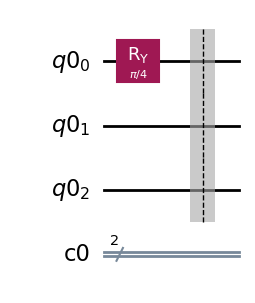

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from math import pi

qr = QuantumRegister(3)    # 3 qubits: q_0 (Alice's data), q_1 (entangled pair), q_2 (Bob's qubit)
cr = ClassicalRegister(2)  # only two classical bits for Alice's measurement
qc = QuantumCircuit(qr, cr)

# Qubit 0 is the one to be teleported (Alice's qubit)
qc.ry(pi/4, 0)  # Change the state of qubit 0 by applying a rotation around the y-axis
qc.barrier()
qc.draw('mpl')

This qubit $q_0$ may be prepared in any state, and does not need to be by Alice. Someone (not even Bob) may prepare a qubit and give it to Alice as $q_0$.

So, we write the state of $q_0$ as:

$$
|q_0\rangle = \alpha |0\rangle + \beta |1\rangle
$$

## Alice creates the entangled pair

We entangle $q_1$ and $q_2$ into a Bell pair. This is done by applying a Hadamard gate to $q_1$, followed by a CNOT gate with $q_1$ as control and $q_2$ as target.

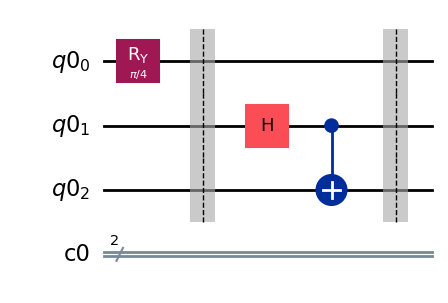

In [2]:
# Entangle qubits 1 and 2
qc.h(1)
qc.cx(1, 2)
qc.barrier()
qc.draw('mpl')

$q_1$ and $q_2$ are now in the Bell state:

$$
|q_1q_2\rangle = |\Phi^+\rangle = \frac{1}{\sqrt{2}} \biggl( |00\rangle + |11\rangle \biggr)
$$

The current state of the circuit is:

$$
\begin{aligned}
|\psi\rangle &= |q_0q_1q_2\rangle = \biggl(\alpha|0\rangle + \beta |1\rangle\biggr) \otimes \frac{1}{\sqrt{2}} \biggl( |00\rangle + |11\rangle \biggr) \\[2ex]
&= \frac{1}{\sqrt{2}} \biggl( \alpha |000\rangle + \alpha |011\rangle + \beta |100\rangle + \beta |111\rangle \biggr) \\[2ex]
\end{aligned}
$$

This superposition is the starting point of the teleportation protocol.

## Alice performs Bell measurement

First, we realize that Alice's qubits $q_0$ and $q_1$ are in a 2-qubit state, which we can express in the Bell basis.

Recall the Bell states:

$$
\begin{aligned}
|\Phi^+\rangle &= \frac{1}{\sqrt{2}} \biggl( |00\rangle + |11\rangle \biggr) \\[2ex]
|\Phi^-\rangle &= \frac{1}{\sqrt{2}} \biggl( |00\rangle - |11\rangle \biggr) \\[2ex]
|\Psi^+\rangle &= \frac{1}{\sqrt{2}} \biggl( |01\rangle + |10\rangle \biggr) \\[2ex]
|\Psi^-\rangle &= \frac{1}{\sqrt{2}} \biggl( |01\rangle - |10\rangle \biggr) \\[2ex]
\end{aligned}
$$

Therefore, $|00\rangle$, $|01\rangle$, $|10\rangle$, and $|11\rangle$ can be expressed as:

$$
\begin{aligned}
|00\rangle &= \frac{1}{\sqrt{2}} \biggl( |\Phi^+\rangle + |\Phi^-\rangle \biggr) \\[2ex]
|01\rangle &= \frac{1}{\sqrt{2}} \biggl( |\Psi^+\rangle + |\Psi^-\rangle \biggr) \\[2ex]
|10\rangle &= \frac{1}{\sqrt{2}} \biggl( |\Psi^+\rangle - |\Psi^-\rangle \biggr) \\[2ex]
|11\rangle &= \frac{1}{\sqrt{2}} \biggl( |\Phi^+\rangle - |\Phi^-\rangle \biggr) \\[2ex]
\end{aligned}
$$

We express Alice's qubits $q_0$ and $q_1$ in the Bell basis:

$$
\begin{aligned}
|\psi\rangle &= \frac{1}{\sqrt{2}} \biggl( \alpha |000\rangle + \alpha |011\rangle + \beta |100\rangle + \beta |111\rangle \biggr) \\[2ex]
&= \frac{1}{\sqrt{2}} \biggl( \alpha \frac{1}{\sqrt{2}} \biggl( |\Phi^+\rangle + |\Phi^-\rangle \biggr) \otimes |0\rangle + \alpha \frac{1}{\sqrt{2}} \biggl( |\Psi^+\rangle + |\Psi^-\rangle \biggr) \otimes |1\rangle + \\
&\qquad\quad\ \ \; \beta \frac{1}{\sqrt{2}} \biggl( |\Psi^+\rangle - |\Psi^-\rangle \biggr) \otimes |0\rangle + \beta \frac{1}{\sqrt{2}} \biggl( |\Phi^+\rangle - |\Phi^-\rangle \biggr) \otimes |1\rangle \biggr) \\[2ex]
&= \frac{1}{2} \biggl[ |\Phi^+\rangle \otimes \biggl( \alpha|0\rangle + \beta|1\rangle\biggr) + |\Phi^-\rangle \otimes \biggl( \alpha|0\rangle - \beta|1\rangle\biggr) + |\Psi^+\rangle \otimes \biggl( \alpha|1\rangle + \beta|0\rangle\biggr) + |\Psi^-\rangle \otimes \biggl( \alpha|1\rangle - \beta|0\rangle\biggr) \biggr] \\[2ex]
&= \frac{1}{2} \biggl[ |\Phi^+\rangle \otimes |q_0\rangle + |\Phi^-\rangle \otimes Z|q_0\rangle + |\Psi^+\rangle \otimes X|q_0\rangle + |\Psi^-\rangle \otimes XZ|q_0\rangle \biggr] \\[2ex]
\end{aligned}
$$

If we measure $q_0$ and $q_1$ in the Bell basis, we will collapse the state into one of the four Bell states.

Then, we know which state Bob's qubit $q_2$ is in, and he can apply the corresponding correction to obtain the original state of $q_0$.

Alice performs a Bell measurement on her two qubits $q_0$ and $q_1$ by applying a CNOT gate from $q_0$ (control) to $q_1$ (target) followed by a Hadamard gate on $q_0$.

This transforms the Bell states into the computational basis as follows:

$$
\begin{aligned}
\text{H}_0 \text{CX}_{01} |\Phi^+\rangle &= \text{H}_0 \text{CX}_{01} \frac{1}{\sqrt{2}} \biggl( |00\rangle + |11\rangle \biggr) = \text{H}_0 \frac{1}{\sqrt{2}} \biggl( |00\rangle + |10\rangle \biggr) = \frac{1}{2} \biggl( |00\rangle + |10\rangle + |00\rangle - |10\rangle \biggr) = |00\rangle \\[2ex]
\text{H}_0 \text{CX}_{01} |\Phi^-\rangle &= \text{H}_0 \text{CX}_{01} \frac{1}{\sqrt{2}} \biggl( |00\rangle - |11\rangle \biggr) = \text{H}_0 \frac{1}{\sqrt{2}} \biggl( |00\rangle - |10\rangle \biggr) = \frac{1}{2} \biggl( |00\rangle + |10\rangle - |00\rangle + |10\rangle \biggr) = |10\rangle \\[2ex]
\text{H}_0 \text{CX}_{01} |\Psi^+\rangle &= \text{H}_0 \text{CX}_{01} \frac{1}{\sqrt{2}} \biggl( |01\rangle + |10\rangle \biggr) = \text{H}_0 \frac{1}{\sqrt{2}} \biggl( |01\rangle + |11\rangle \biggr) = \frac{1}{2} \biggl( |01\rangle + |11\rangle + |01\rangle - |11\rangle \biggr) = |01\rangle \\[2ex]
\text{H}_0 \text{CX}_{01} |\Psi^-\rangle &= \text{H}_0 \text{CX}_{01} \frac{1}{\sqrt{2}} \biggl( |01\rangle - |10\rangle \biggr) = \text{H}_0 \frac{1}{\sqrt{2}} \biggl( |01\rangle - |11\rangle \biggr) = \frac{1}{2} \biggl( |01\rangle + |11\rangle - |01\rangle + |11\rangle \biggr) = |11\rangle \\[2ex]
\end{aligned}
$$

So measuring $q_0$ and $q_1$ in the computational basis after this transformation is equivalent to performing a Bell measurement.

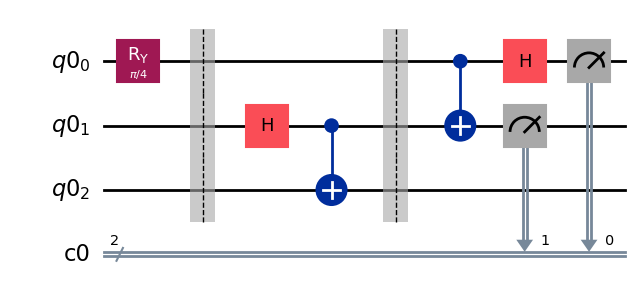

In [3]:
# Bell measurement
qc.cx(0, 1)       # Entangles qubit 0 with 1 (control = q_0, target = q_1)
qc.h(0)           # Completes the Bell measurement (Measurement in the Bell basis)
qc.measure(qr[0], cr[0])  # Measure qubit 0 into classical bit 0
qc.measure(qr[1], cr[1])  # Measure qubit 1 into classical bit 1
qc.draw('mpl')

Alice's measurement will yield one of the four Bell states. She only needs to do this once. 

But here we will simulate it many times to see the distribution of the results. 

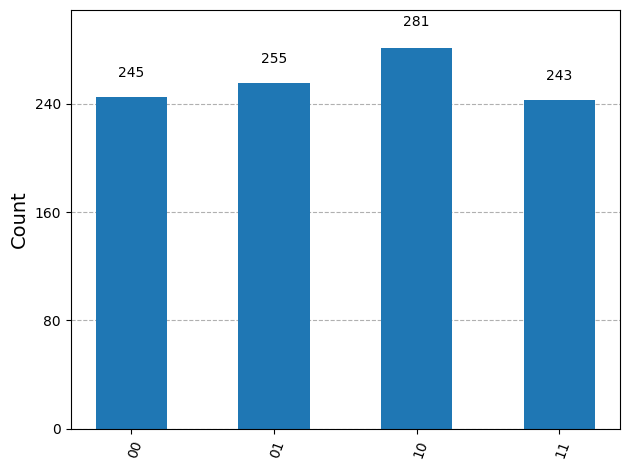

In [4]:
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

backend = AerSimulator()
compiled = transpile(qc, backend)
job = backend.run(compiled, shots=1024)
result = job.result()
counts = result.get_counts()

plot_histogram(counts)

**Note on bit order:**  
Qiskit uses little-endian ordering when returning measurement results. This means that a bitstring like `'10'` corresponds to:

- `c[1] = 1` (measurement of `q_1`)
- `c[0] = 0` (measurement of `q_0`)

So `'10'` represents:

$$
|q_1 q_0\rangle = |10\rangle \quad \text{which is} \quad |q_0 q_1\rangle = |01\rangle
$$

In other words, the bitstrings shown in the histogram (e.g., `'01'`, `'10'`) represent classical measurement outcomes ordered as `[q_1, q_0]`, which corresponds to $|q_0 q_1\rangle$ in the equations. This is important to remember when interpreting the results.


After Alice performs a Bell measurement on her two qubits (`q_0` and `q_1`), the system collapses into one of the four Bell states. The mapping between Qiskit's measurement results and the corresponding Bell states is:

| Qiskit result `'c[1]c[0]'` | Qubit values \|q_0 q_1>  | Bell state        |
|----------------------------|--------------------------|-------------------|
| `'00'`                     | \|00>                    | $\Phi^+$          |
| `'01'`                     | \|10>                    | $\Phi^-$          |
| `'10'`                     | \|01>                    | $\Psi^+$          |
| `'11'`                     | \|11>                    | $\Psi^-$          |

As seen in the histogram, these outcomes appear with roughly equal probability (with small variations due to simulation noise), as expected from an ideal Bell measurement.

Alice only performs this measurement once, then sends the resulting **two classical bits** to Bob through a classical channel. These bits are all the information Bob needs to determine the correct **Pauli correction** to recover the original quantum state on his qubit.


## Bob applies correction using classical bits from Alice

Recall that the state of the circuit after Alice's Bell measurement is:

$$
|\psi\rangle = \frac{1}{2} \biggl[ |\Phi^+\rangle \otimes |q_0\rangle + |\Phi^-\rangle \otimes Z|q_0\rangle + |\Psi^+\rangle \otimes X|q_0\rangle + |\Psi^-\rangle \otimes XZ|q_0\rangle \biggr]
$$

The Pauli gates X and Z are self-inverse, meaning:

$$
X^2 = I \quad \text{and} \quad Z^2 = I
$$

This makes them ideal for corrections — applying the same gate again reverses the effect.

Bob applies corrections based on the classical bits sent by Alice:

- If Alice measured `00` corresponding to $|\Phi^+\rangle$, no correction is needed
- If Alice measured `10` corresponding to $|\Phi^-\rangle$, Bob applies Z
- If Alice measured `01` corresponding to $|\Psi^+\rangle$, Bob applies X
- If Alice measured `11` corresponding to $|\Psi^-\rangle$, Bob applies ZX

Let’s build a new circuit that includes these conditional operations.

## Conclusion

Quantum teleportation enables the transfer of an unknown quantum state from one qubit to another — without physically transmitting the qubit itself. This remarkable protocol works by leveraging the unique principles of quantum mechanics:

- **Entanglement**: A shared Bell pair links the sender and receiver qubits.
- **Measurement**: The sender performs a joint measurement in the Bell basis, collapsing the system.
- **Classical communication**: Two classical bits are sent to the receiver.
- **Correction**: The receiver uses this information to apply a transformation that reconstructs the original state.

Quantum teleportation is not just a theoretical curiosity — it is a cornerstone for emerging technologies like quantum networks, quantum repeaters, distributed quantum computing, and secure quantum communication.
